# Fold arbitrary fluxes through MagEIS isotropic response functions and compare with the official fluxes

This notebook explores how the flux calculated using the Bayes method compares to the publically avaliable values.

The steps are almost the same as the 2018-06-29_iso_R_arbitrary_spectra notebook, but uses the true MagEIS low count rates.

In [40]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.integrate
sns.set(font_scale=1.5)
%matplotlib inline
import sys

sys.path.append('../utils/')
import mageis_response

### Create a true exponential spectra with E0t and J0t parameters. 
Then use that spectra and fold it through the MagEIS response functions to get true counts as a function of energy channel.

In [41]:
# Initialize the response function
# RBSP-A MagEIS LOW LUT=16386 from 2016-01-01 (same for all day)
R = mageis_response.R_iso(101, lut=16386, magB=1065)
print('Using MagEIS calibration file: {}'.format(R._cal_file))
E = 1000*R.E # energy (keV).
n_ch = (1, 9) # Use the main rate channels and ignore the first channel (is it junk?)

Using MagEIS calibration file: /home/msshumko/Documents/mageis-stats/utils/mageis_response_files/low/rbsp_mageis_low_101_1065_MR_16386.mat


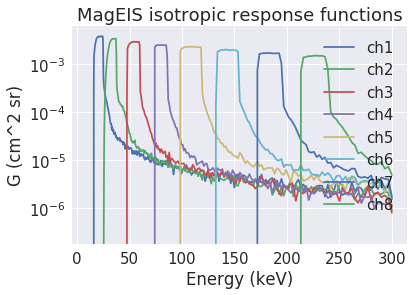

In [42]:
for i in range(*n_ch):
    plt.plot(E, R.response(i), label='ch{}'.format(i));
plt.xlabel('Energy (keV)'); plt.ylabel('G (cm^2 sr)'); 
plt.title('MagEIS isotropic response functions'); plt.yscale('log');
plt.legend(); #plt.savefig('response.png', dpi=300)

The observed count rates and the official flux from 2016-01-01T00:00:02.823000

In [43]:
c_obs = np.array([33758.242, 30543.17, 17682.889, 12860.282,
       10047.096, 2411.303, 1105.1805, 552.5903]) # Counts/s
FEDU = [1.2161670e+06, 1.1864615e+06, 5.3590431e+05,
        4.5189862e+05, 2.2285083e+05, 5.6950922e+04, 2.7401449e+04,
        1.4226637e+04] # Flux from Channels 1-9 (cm^2 s sr keV)^-1
FEDU_energy = [ 15.,  20.,  33.,  54.,  80., 108., 143., 184., 226.] # keV

### Model the energy channel-dependent flux 

In [44]:
# Define the energy channel boundaries for the spectra
nE = 5
E_bins = np.linspace(E[0], E[-1], num=nE+1)
istart = [np.where(E >= i)[0][0] for i in E_bins][:-1]
iend = [np.where(E <= i)[0][-1] for i in E_bins][1:]

In [46]:
def pymcTrapz(f, x):
    """
    This function is the pymc3 Trapz implementation for an uneven grid.
    It integrates a function f over an uneven grid x.
    """
    return 0.5*pm.math.dot((f[1:] + f[:-1]), (x[1:] - x[:-1]))

def lam(JJ):
    """
    This function appears to the only way to correctly work with pymc3 and 
    propagate the sampled spectra though the instrument response functions.
    """
    lams = (n_ch[1]-n_ch[0])*[0] 
    
    for ch in range(*n_ch):
        # Reset count counter.
        ch_c = 0 
        for i in range(nE):
            # Fold the flux through R
            f = pm.math.dot(JJ[i], R.response(ch)[istart[i]:iend[i]])
            # Calc count contribution to chth energy channel by the ith flux.
            ch_c += pymcTrapz(f, E[istart[i]:iend[i]]) 
        # Save the total counts in chth energy channel from 
        # contributions from all of the fluxes.
        lams[ch-n_ch[0]] = pm.Deterministic('lam{}'.format(ch), ch_c)
    return lams

# Prior exponential spectra assumption
E0g = 100 # keV
J0g = 1E7 # (cm^2 sr s keV)^-1
muArr = J0g*np.exp(-E_bins[1:]/E0g)

m = pm.Model()
with m:
    # Prior stocastic variables
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0) # Do not allow negative fluxes.
    J = BoundedNormal('J', mu=muArr, sd=1E5,  shape=nE)
    
    lams = lam(J) # Get the count values from the picked J array of values.
    c_m = pm.Poisson('c_m', mu=lams, observed=c_obs, shape=len(c_obs))
    trace = pm.sample(1E4, tuning=1000, cores=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [J_lowerbound__]
100%|██████████| 10500/10500.0 [1:13:41<00:00,  2.37it/s]
The acceptance probability does not match the target. It is 0.9507556433129195, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.8985140571130181, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9473850616825288, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


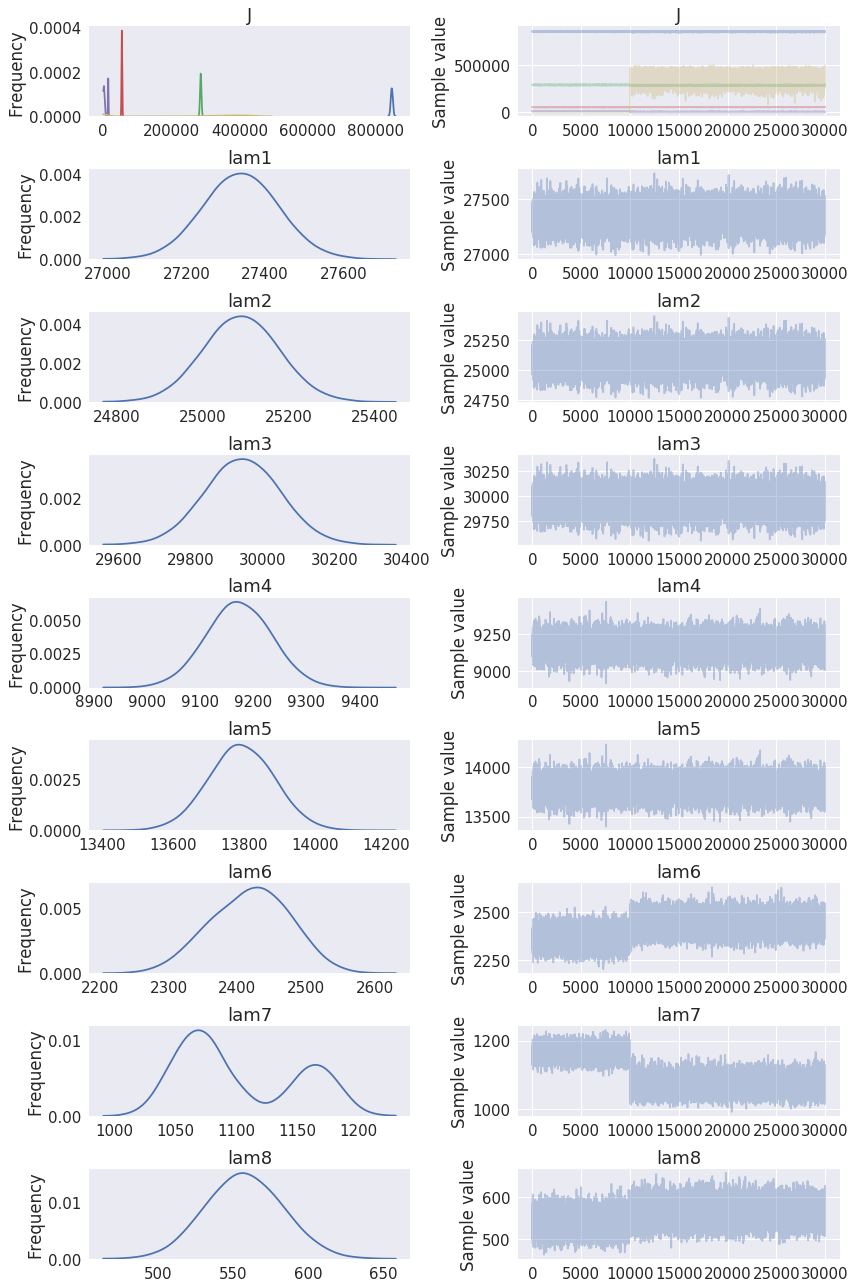

In [47]:
pm.traceplot(trace, combined=True);

In [48]:
pm.summary(trace)

mean             sd      mc_error        hpd_2.5  \
J__0  847492.313309    3065.637891     64.846441  841468.427711   
J__1  286373.547568    1974.729013     52.434487  282603.969117   
J__2   54773.188192    1009.340552     13.573698   52751.766899   
J__3    6804.782589    5800.098236    556.432856      48.061140   
J__4  243530.789046  178205.736332  17140.212517       1.232965   
lam1   27337.558813      96.023172      0.667824   27149.603562   
lam2   25087.749335      88.057766      0.569700   24913.073287   
lam3   29942.435162     105.114696      0.860761   29732.766438   
lam4    9171.871235      60.734280      0.466331    9054.886932   
lam5   13790.747146      91.138332      0.771989   13612.905321   
lam6    2417.750476      57.568989      3.670466    2302.080057   
lam7    1101.503609      49.185105      4.418551    1031.739009   
lam8     557.032407      25.529577      1.088341     506.852542   

           hpd_97.5         n_eff      Rhat  
J__0  853506.679994     40.352217  1.031899  
J__1  290355.802856     21.216768  1.051281  
J__2   56722.595274   1111.096432  1.010777  
J__3   15362.182999      1.579975  4.517073  
J__4  439132.475616      1.574316  4.686544  
lam1   27526.897478  17725.720907  1.000505  
lam2   25259.381039  17808.077407  1.000028  
lam3   30145.007987  17367.421744  1.002002  
lam4    9293.286643  18415.918493  1.000236  
lam5   13969.909231  18321.483095  1.001272  
lam6    2522.442737      3.031487  1.426274  
lam7    1189.981607      1.736888  2.742738  
lam8     606.305222      6.469304  1.153980

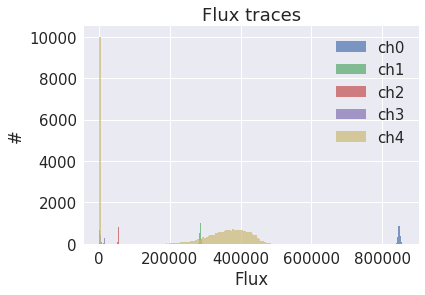

In [49]:
for ch in range(nE):
    plt.hist(trace['J'][:, ch], alpha=0.7, bins=100, label='ch{}'.format(ch))
plt.legend(); plt.title('Flux traces'); plt.ylabel('#'); plt.xlabel('Flux');

Now use the traces to calculate the modeled counts and uncertainties, as well as the flux means and stds.

In [50]:
c_mean = [np.mean(trace['lam{}'.format(i)]) for i in range(*n_ch)]
c_std = [np.std(trace['lam{}'.format(i)]) for i in range(*n_ch)]
c_Err = np.asarray([np.percentile(trace['lam{}'.format(i)], (2.5, 97.5)) 
                    for i in range(*n_ch)])

j_mean = np.mean(trace['J'], axis=0)
j_std = np.std(trace['J'], axis=0)
j_ci = np.percentile(trace['J'], (2.5, 97.5), axis=0) 

In [51]:
plt.plot(np.arange(*n_ch), c_obs, 'go', label='observed counts', ms=10);
plt.errorbar(np.arange(*n_ch), c_mean, fmt='ro', yerr=c_std, label='modeled counts', ms=5);
plt.legend(); plt.title('True vs modeled counts'); plt.xlabel('Energy channel');
plt.ylabel('Counts');

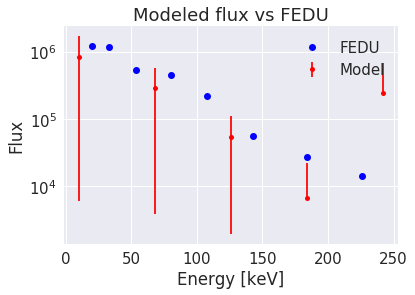

In [53]:
plt.errorbar(E_bins[:-1], j_mean, 
             fmt='ro', yerr=j_ci, label='Model', ms=5);
#plt.plot(np.arange(*n_ch), official_flux, 'bo', label='Official')
plt.plot(FEDU_energy[1:], np.array(FEDU), 'bo', label='FEDU')
plt.title('Modeled flux vs FEDU'); plt.xlabel('Energy [keV]'); plt.ylabel('Flux');
plt.yscale('log'); plt.legend(); #plt.savefig('flux_compare.png', dpi=300)